In [1]:
!pip install torch torchvision


In [52]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
import numpy as np


from PIL import Image, ImageOps
import matplotlib.pyplot as plt

In [36]:
#Training Data from MNIST Dataset
training_data = datasets.MNIST(root = 'Data', train = 'True', download = 'True', transform = ToTensor(),)
#Test Data from MNIST
test_data = datasets.MNIST(root = 'Data', train = 'False', download = 'True', transform = ToTensor(),)

batch_size = 64

#dataloaders for iterate over data
training_dataloader = DataLoader(training_data,batch_size=batch_size)
test_dataloader = DataLoader(test_data,batch_size = batch_size)

Training_Data_Size = len(training_data)*batch_size
Test_Data_Size = len(test_data)*batch_size

print(Training_Data_Size)
print(Test_Data_Size)

for X,y in test_dataloader:
  print(f'Shape of X[N,C,H,W] : {X.shape}')
  print(f'Shape of y: {y.shape} {y.dtype}')
  break

3840000
3840000
Shape of X[N,C,H,W] : torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [37]:
# device for training.
device = torch.device(
    "cuda" if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device} device")

# model
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_classes)
        )

    def forward(self, image_tensor):
        image_tensor = self.flatten(image_tensor)
        logits = self.linear_relu_stack(image_tensor)
        return logits


input_size = 28*28
hidden_size = 512
num_classes = 10

model = NeuralNetwork(input_size, hidden_size, num_classes).to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [64]:
# input image transformation
transform = transforms.Compose([
    transforms.ToTensor()
])


In [45]:
# learning rate, loss function and optimizer
learning_rate = 1e-3 # 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# training function
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()

    for batch_num, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Forward pass to compute prediction
        pred = model(X)
        # Compute prediction error using loss function
        loss = loss_fn(pred, y)

        # Backward pass
        optimizer.zero_grad() # zero any previous gradient calculations
        loss.backward() # calculate gradient
        optimizer.step() # update model parameters

        if batch_num > 0 and batch_num % 100 == 0:
            loss, current = loss.item(), batch_num * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [46]:
# test function
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        pred = model(X)
        test_loss += loss_fn(pred, y).item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [47]:
# model training
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(training_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.006352  [ 6400/60000]
loss: 0.116988  [12800/60000]
loss: 0.031606  [19200/60000]
loss: 0.014702  [25600/60000]
loss: 0.002831  [32000/60000]
loss: 0.003434  [38400/60000]
loss: 0.008678  [44800/60000]
loss: 0.149814  [51200/60000]
loss: 0.013363  [57600/60000]
Test Error: 
 Accuracy: 98.4%, Avg loss: 0.058403 

Epoch 2
-------------------------------
loss: 0.000530  [ 6400/60000]
loss: 0.080303  [12800/60000]
loss: 0.011836  [19200/60000]
loss: 0.104227  [25600/60000]
loss: 0.009682  [32000/60000]
loss: 0.000885  [38400/60000]
loss: 0.014653  [44800/60000]
loss: 0.040300  [51200/60000]
loss: 0.053836  [57600/60000]
Test Error: 
 Accuracy: 99.1%, Avg loss: 0.026638 

Epoch 3
-------------------------------
loss: 0.045166  [ 6400/60000]
loss: 0.003195  [12800/60000]
loss: 0.000566  [19200/60000]
loss: 0.002927  [25600/60000]
loss: 0.014013  [32000/60000]
loss: 0.055688  [38400/60000]
loss: 0.002679  [44800/60000]
loss: 0.003461  [51200/600

Saved PyTorch Model State to ml_with_pytorch_model.pth


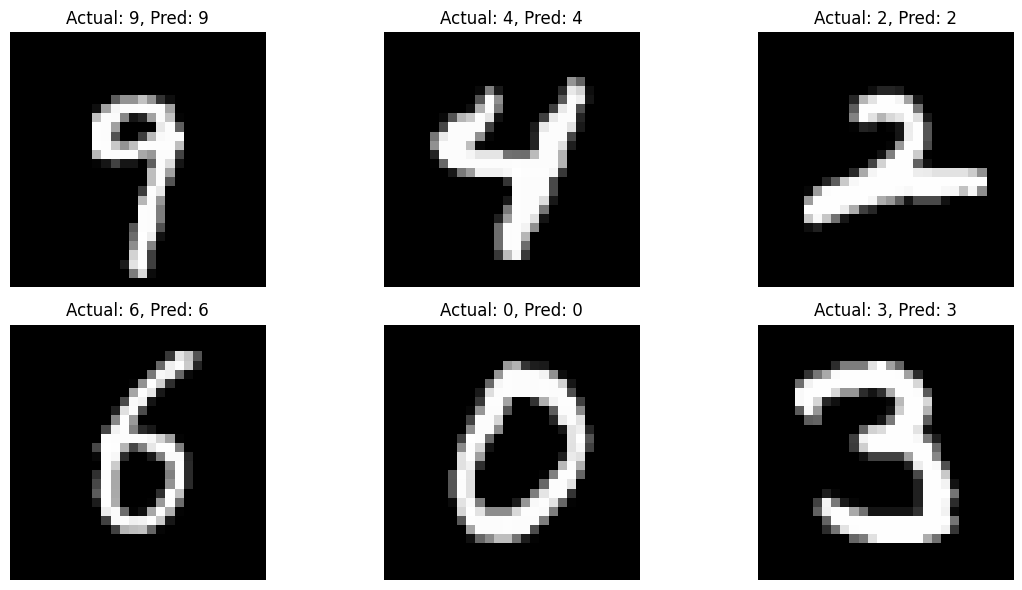

In [63]:
# saving model parameters
torch.save(model.state_dict(), "ml_with_pytorch_model.pth")
print("Saved PyTorch Model State to ml_with_pytorch_model.pth")

# Loading the saved model parameters into a new instance of the model
model = NeuralNetwork(input_size, hidden_size, num_classes).to(device)
model.load_state_dict(torch.load("ml_with_pytorch_model.pth"))

image_data = [
    ("d1.png", 9),
    ("d2.png", 4),
    ("d3.png", 2),
    ("d4.png", 6),
    ("d5.png", 0),
    ("d6.png", 3)
]

model.eval()
plt.figure(figsize=(12, 6))

#Infernce using new model instance
for i in range(len(image_data)):
    path, actual = image_data[i]
    img = Image.open(path)
    x = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(x)
        pred = output.argmax(1).item()

    plt.subplot(2, 3, i + 1)
    plt.imshow(img, cmap="gray")
    plt.title(f"Actual: {actual}, Pred: {pred}")
    plt.axis("off")

plt.tight_layout()
plt.show()
